In [2]:
import numpy as np
import os
from sklearn import svm
from dataloader import Dataloader
import tensorflow as tf
from utils import generate_submission
from utils import plot_histogram
from sklearn.metrics import roc_auc_score, roc_curve, auc
from easydict import EasyDict as ed
import matplotlib.pyplot as plt

## Network Configuration

In [3]:
cfg = ed()
root = os.getcwd()

# data path 
cfg.dataloader = ed()
cfg.dataloader.data_path = os.path.join(root, 'data')
cfg.dataloader.feature_raw = os.path.join(cfg.dataloader.data_path, 'feature.xlsx')
# config which part of the data will be used
cfg.dataloader.feature_cell = ['C3', 'DB985']
cfg.dataloader.train_label = os.path.join(cfg.dataloader.data_path, 'train_label.csv')

# number of training data
cfg.dataloader.num_train_data = 683
# portion of training set used as validation set
cfg.dataloader.num_validation_portion = 0.1

# probalility of sampling important data for training
cfg.dataloader.im_sampling_rate = 0.3

# data preprocess config
# pca
cfg.dataloader.pca = ed()
cfg.dataloader.pca.enable_pca = False
cfg.dataloader.pca.max_to_keep = 120
# remove empty column
cfg.dataloader.remove_empty_col = True
# normalize each column
cfg.dataloader.columnwise_normalize = True
# categorize columns
cfg.dataloader.categorize_column = False

# rnn
cfg.rnn = ed()
cfg.rnn.hidden_size = 128
cfg.rnn.hist_size = 5
cfg.rnn.batch_size = 10
cfg.rnn.train_iter = 30000

cfg.rnn.learning_rate = 0.1
cfg.rnn.decay_step = 5000
cfg.rnn.decay_rate = 0.9
cfg.rnn.clip_norm = 1.25

cfg.rnn.drop_out = True
cfg.rnn.dropout_rate = 0.5

cfg.rnn.batch_normalization = False

cfg.rnn.load_pretrained = False	
cfg.rnn.model_path = os.path.join(root, 'rnn_model')
cfg.rnn.logdir = os.path.join(root, 'rnn_log')

cfg.rnn.validation_freq = 10
cfg.rnn.save_step = 10000
cfg.rnn.num_important_sample = 0



## Defining the RNN Model (either GRU, LSTM, Vanilla)

In [4]:
class RNN:
	def __init__(self, dataloader,modeltype='gru'):

		print('=====Initializing rnn=====')
		# training config
		self.batch_size = cfg.rnn.batch_size
		self.hist_size = cfg.rnn.hist_size
		self.train_iter = cfg.rnn.train_iter
		self.learning_rate = cfg.rnn.learning_rate
		self.decay_step = cfg.rnn.decay_step 
		self.decay_rate = cfg.rnn.decay_rate
		self.clip_norm = cfg.rnn.clip_norm


		# network input
		self.input = tf.placeholder(tf.float32, shape = [None, self.hist_size, dataloader.feature_dim])
		self.labels = tf.placeholder(tf.float32, shape = [None])



		if modeltype== 'gru':
			# network body
			self.gru_cell = tf.contrib.rnn.GRUCell(cfg.rnn.hidden_size)
			rnn_out, self.last_state = tf.nn.dynamic_rnn(self.gru_cell, self.input, dtype=tf.float32)
		elif modeltype=='lstm':
			# network body
			self.lstm_cell = tf.contrib.rnn.LSTMCell(cfg.rnn.hidden_size)
			lstm_out, tup = tf.nn.dynamic_rnn(self.lstm_cell, self.input, dtype=tf.float32)
			_,self.last_state = tup
		elif modeltype=='vanilla':
			self.vanillarnn_cell = tf.contrib.rnn.BasicRNNCell(cfg.rnn.hidden_size)
			rnn_out, self.last_state = tf.nn.dynamic_rnn(self.vanillarnn_cell,self.input,dtype=tf.float32)



		self.enable_dropout = cfg.rnn.drop_out
		if self.enable_dropout:
			self.keep_prob = tf.placeholder(tf.float32)
			self.last_state = tf.nn.dropout(self.last_state, self.keep_prob)
			self.dropout_rate = cfg.rnn.dropout_rate

		# network output
		self.logit = tf.squeeze(tf.layers.dense(self.last_state, 1))
		self.pred = tf.nn.sigmoid(self.logit)

		# loss function
		self.loss_func = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = self.logit, labels = self.labels))
		self.opt = self.__get_optimizer()

		# other config
		self.dataloader = dataloader
		self.num_important_sample = cfg.rnn.num_important_sample

		self.sess = tf.InteractiveSession()
		self.sess.run(tf.global_variables_initializer())
		self.validation_freq = cfg.rnn.validation_freq
		self.save_step = cfg.rnn.save_step
		self.model_path = cfg.rnn.model_path + '/' + modeltype
		if not os.path.exists(self.model_path):
			os.makedirs(self.model_path)

		# tensorboard
		tf.summary.scalar('rnn_loss', self.loss_func)
		self.sum_writer = tf.summary.FileWriter(cfg.rnn.logdir+modeltype, self.sess.graph)
		self.summary_merge = tf.summary.merge_all()

		# load pretrained model
		self.saver = tf.train.Saver()
		if cfg.rnn.load_pretrained:
			checkpoint = tf.train.get_checkpoint_state(self.model_path)
			if checkpoint and checkpoint.model_checkpoint_path:
				self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
				print('Successfully loaded:', checkpoint.model_checkpoint_path)
			else:
				print('Could not find old network weights')
		print('=====Done=====')
        
	def __get_optimizer(self):
		assert not self.loss_func is None

		global_step = tf.Variable(0, trainable = False)
		learning_rate = tf.train.exponential_decay(self.learning_rate, global_step, 
	    										   self.decay_step, self.decay_rate, staircase = True)
		optimizer = tf.train.GradientDescentOptimizer(learning_rate)
		gradients, v = zip(*optimizer.compute_gradients(self.loss_func))
		gradients, _ = tf.clip_by_global_norm(gradients, self.clip_norm)
		optimizer = optimizer.apply_gradients(zip(gradients, v), global_step = global_step)

		return optimizer
    
    
	def train(self):
		print('=====Training Start=====')
		print('Initial learning rate:', self.learning_rate)
		print('History size:', self.hist_size)
		print('Number of iteration:', self.train_iter)
		if self.enable_dropout:
			print('Dropout rate: ', self.dropout_rate)

		for i in range(1, self.train_iter):
			batch = self.dataloader.next_batch(self.batch_size, self.num_important_sample)
			inputs, labels = zip(*batch)
			feed_dict = {self.input: list(inputs), self.labels: list(labels)}
			if self.enable_dropout:
				feed_dict[self.keep_prob] = self.dropout_rate

			# train
			_, log, loss = self.sess.run([self.opt, self.summary_merge, self.loss_func], feed_dict = feed_dict)
			if i % 100 == 0:
				print('Iteration #%i, loss:%s' %(i, loss))

			# write to tensorboard
			self.sum_writer.add_summary(log, i)
			# save model
			if i % self.save_step == 0:
				self.saver.save(self.sess, self.model_path, global_step = i)
				print('Model saved in %ith iteration' %i)
    

			# validation
			if i % 5000 == 0:
				self.validation()
				batch = []
				for i in range(self.dataloader.train_feature.shape[0] - self.hist_size + 1):
					batch.append(self.dataloader.train_feature[i:(i + self.hist_size)])
                
				ground_truth = self.dataloader.train_label[(self.hist_size - 1):]
				test_feature = np.array(batch)

				feed_dict = {self.input:test_feature}
				if self.enable_dropout:
					feed_dict[self.keep_prob] = 1

				result = self.sess.run(self.pred, feed_dict = feed_dict)
				auc = roc_auc_score(ground_truth, result)
				print('The fitted accuracy is:', auc)


		print('=====Training Done!=====')

	def __make_bound(self, data):
		assert len(data.shape) == 1
		for i in range(data.shape[0]):
			if data[i] < 0.005:
				data[i] = 0.005
			elif data[i] > 0.995:
				data[i] = 0.995

	def test(self):
		print('=====Generating test result=====')
		# test_feature = np.expand_dims(self.dataloader.test_feature, axis = 0)
		batch = []
		for i in range(self.dataloader.test_feature.shape[0] - self.hist_size + 1):
			batch.append(self.dataloader.test_feature[i:(i + self.hist_size)])

		test_feature = np.array(batch)

		feed_dict = {self.input:test_feature}
		if self.enable_dropout:
			feed_dict[self.keep_prob] = 1

		result = self.sess.run(self.pred, feed_dict = feed_dict)
# 		self.__make_bound(result)

		generate_submission(result, '.', '.')
		print('=====Done=====')

	def validation(self):
		batch = []
		for i in range(self.dataloader.val_feature.shape[0] - self.hist_size + 1):
			batch.append(self.dataloader.test_feature[i:(i + self.hist_size)])

		ground_truth = self.dataloader.val_label[(self.hist_size - 1):]
		test_feature = np.array(batch)

		feed_dict = {self.input:test_feature}
		if self.enable_dropout:
			feed_dict[self.keep_prob] = 1

		result = self.sess.run(self.pred, feed_dict = feed_dict)

		# bound the prediction value
# 		self.__make_bound(result)

		aucscore = roc_auc_score(ground_truth, result)

		print('The validation accuracy is:', aucscore)
        
        #plot ROC curve
		fpr, tpr, _ = roc_curve(ground_truth, result)
		rocauc = auc(fpr, tpr)
		plt.figure()
		lw = 2
		plt.plot(fpr, tpr, color='darkorange',
                         lw=lw, label='ROC curve (area = %0.2f)' % rocauc)
		plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
		plt.xlim([0.0, 1.0])
		plt.ylim([0.0, 1.05])
		plt.xlabel('False Positive Rate')
		plt.ylabel('True Positive Rate')
		plt.title('Receiver operating characteristic example')
		plt.legend(loc="lower right")
		plt.show()
        


dataloader = Dataloader(cfg.rnn.hist_size)

==========set up dataloader==========
----Important Samples----
data size: 33
hist size: 5
-------------------------
Train feature shape: (615, 101)
Train label shape: (615,)
Validation feature shape: (68, 101)
Validation label shape: (68,)
Test feature shape: (304, 101)
PCA: False
Remove empty column: True
Column-wise normalize: False
categorize column: True
==========done==========


## Create an RNN model and train on it
In the training log, 'fitted accuracy' means the accuracy of training data in terms of auc score while the 'validation accuracy' is the the accuracy of the validation data, which is unseen by the model.


=====Initializing rnn=====
Instructions for updating:
Use the retry module or similar alternatives.
=====Done=====
=====Training Start=====
Initial learning rate: 0.1
History size: 5
Number of iteration: 30000
Dropout rate:  0.5
Iteration #100, loss:0.08094362
Iteration #200, loss:0.053498767
Iteration #300, loss:0.08051451
Iteration #400, loss:0.06594648
Iteration #500, loss:0.0812119
Iteration #600, loss:0.24013285
Iteration #700, loss:0.31605345
Iteration #800, loss:0.58553374
Iteration #900, loss:0.4272391
Iteration #1000, loss:0.12079557
Iteration #1100, loss:0.03793865
Iteration #1200, loss:0.11555014
Iteration #1300, loss:0.4419238
Iteration #1400, loss:0.08672923
Iteration #1500, loss:0.12514013
Iteration #1600, loss:0.028645614
Iteration #1700, loss:0.41010994
Iteration #1800, loss:0.018145453
Iteration #1900, loss:0.053763438
Iteration #2000, loss:0.23188913
Iteration #2100, loss:0.026999723
Iteration #2200, loss:0.03886334
Iteration #2300, loss:0.024620075
Iteration #2400, l

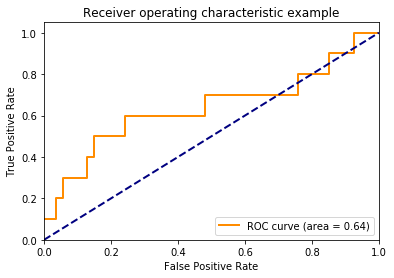

The fitted accuracy is: 0.8564013840830449
Iteration #5100, loss:0.030237472
Iteration #5200, loss:0.093727395
Iteration #5300, loss:0.300447
Iteration #5400, loss:0.009397203
Iteration #5500, loss:0.03933012
Iteration #5600, loss:0.024132706
Iteration #5700, loss:0.012666227
Iteration #5800, loss:0.056277044
Iteration #5900, loss:0.0024305517
Iteration #6000, loss:0.018226845
Iteration #6100, loss:0.00013869602
Iteration #6200, loss:0.04071115
Iteration #6300, loss:0.0042243376
Iteration #6400, loss:0.005241913
Iteration #6500, loss:0.005033799
Iteration #6600, loss:0.00025637267
Iteration #6700, loss:0.00021374552
Iteration #6800, loss:0.0016648313
Iteration #6900, loss:0.01435411
Iteration #7000, loss:0.015243785
Iteration #7100, loss:0.0010175474
Iteration #7200, loss:0.0025729234
Iteration #7300, loss:0.010551039
Iteration #7400, loss:0.16394642
Iteration #7500, loss:0.0037976925
Iteration #7600, loss:0.26474583
Iteration #7700, loss:0.006277879
Iteration #7800, loss:0.0004844234


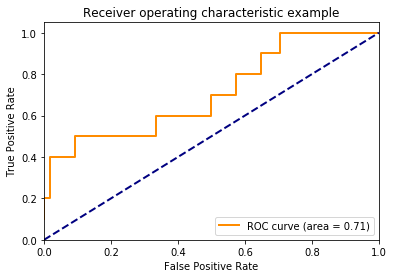

The fitted accuracy is: 0.8387333543042885
Iteration #10100, loss:0.00014462358
Iteration #10200, loss:5.1559116e-05
Iteration #10300, loss:5.4070297e-06
Iteration #10400, loss:0.004269928
Iteration #10500, loss:6.949805e-07
Iteration #10600, loss:0.004340511
Iteration #10700, loss:4.3998072e-05
Iteration #10800, loss:0.00029182417
Iteration #10900, loss:0.0005311308
Iteration #11000, loss:2.2860751e-05
Iteration #11100, loss:0.0002699224
Iteration #11200, loss:2.013452e-05
Iteration #11300, loss:0.00014137043
Iteration #11400, loss:0.00013581385
Iteration #11500, loss:0.0057531195
Iteration #11600, loss:2.8606033e-05
Iteration #11700, loss:7.1006906e-07
Iteration #11800, loss:5.163942e-05
Iteration #11900, loss:0.009652863
Iteration #12000, loss:0.00013482077
Iteration #12100, loss:4.715187e-06
Iteration #12200, loss:6.1360515e-06
Iteration #12300, loss:0.0006040807
Iteration #12400, loss:0.00181055
Iteration #12500, loss:0.0013880616
Iteration #12600, loss:7.431908e-06
Iteration #127

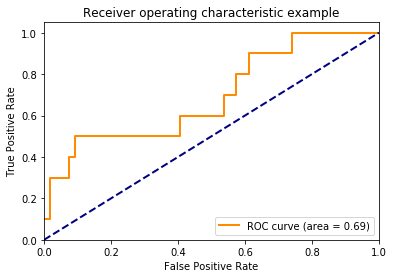

The fitted accuracy is: 0.8386284995281535
Iteration #15100, loss:5.906405e-06
Iteration #15200, loss:0.0009444876
Iteration #15300, loss:1.3868409e-05
Iteration #15400, loss:0.0005743393
Iteration #15500, loss:0.0032662922
Iteration #15600, loss:0.0017484108
Iteration #15700, loss:3.9885297e-05
Iteration #15800, loss:8.5698615e-05
Iteration #15900, loss:2.7150474e-05
Iteration #16000, loss:1.7619652e-05
Iteration #16100, loss:9.737461e-05
Iteration #16200, loss:5.678975e-07
Iteration #16300, loss:1.6820597e-05
Iteration #16400, loss:7.696927e-06
Iteration #16500, loss:0.00038769934
Iteration #16600, loss:1.3605332e-06
Iteration #16700, loss:8.6412605e-05
Iteration #16800, loss:1.2119906e-05
Iteration #16900, loss:0.00036852135
Iteration #17000, loss:1.6464897e-05
Iteration #17100, loss:2.8195343e-05
Iteration #17200, loss:0.00019329012
Iteration #17300, loss:1.9923205e-05
Iteration #17400, loss:2.2451272e-06
Iteration #17500, loss:0.00012966091
Iteration #17600, loss:0.000829748
Itera

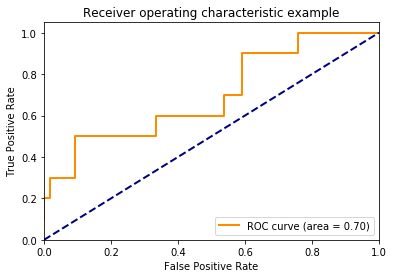

The fitted accuracy is: 0.847436300723498
Iteration #20100, loss:0.00015500713
Iteration #20200, loss:3.4353317e-05
Iteration #20300, loss:2.3662098e-05
Iteration #20400, loss:8.941635e-05
Iteration #20500, loss:2.3528208e-05
Iteration #20600, loss:1.6009031e-06
Iteration #20700, loss:0.0034338802
Iteration #20800, loss:0.00032533956
Iteration #20900, loss:2.6367497e-05
Iteration #21000, loss:3.5625308e-06
Iteration #21100, loss:9.218662e-05
Iteration #21200, loss:0.0004087048
Iteration #21300, loss:0.00037733477
Iteration #21400, loss:6.8940316e-09
Iteration #21500, loss:0.00040840713
Iteration #21600, loss:0.00032546758
Iteration #21700, loss:0.00030102688
Iteration #21800, loss:6.107862e-06
Iteration #21900, loss:0.00114261
Iteration #22000, loss:2.819298e-07
Iteration #22100, loss:2.0042226e-05
Iteration #22200, loss:0.000262055
Iteration #22300, loss:5.756708e-05
Iteration #22400, loss:9.548531e-06
Iteration #22500, loss:0.00013068087
Iteration #22600, loss:8.294092e-06
Iteration 

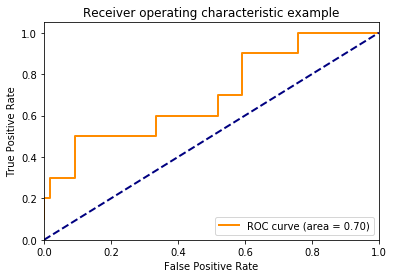

The fitted accuracy is: 0.842560553633218
Iteration #25100, loss:0.000109301225
Iteration #25200, loss:7.66284e-07
Iteration #25300, loss:0.0002948636
Iteration #25400, loss:3.3926943e-07
Iteration #25500, loss:1.5183842e-05
Iteration #25600, loss:1.4461783e-06
Iteration #25700, loss:2.961348e-06
Iteration #25800, loss:3.6366975e-05
Iteration #25900, loss:0.00019325085
Iteration #26000, loss:9.3185445e-05
Iteration #26100, loss:3.7153518e-06
Iteration #26200, loss:6.671117e-08
Iteration #26300, loss:1.3027411e-05
Iteration #26400, loss:4.8234455e-05
Iteration #26500, loss:0.00010936682
Iteration #26600, loss:1.6604045e-05
Iteration #26700, loss:9.795353e-06
Iteration #26800, loss:1.3317195e-05
Iteration #26900, loss:7.664991e-08
Iteration #27000, loss:2.0028167e-05
Iteration #27100, loss:6.854203e-05
Iteration #27200, loss:2.3518571e-06
Iteration #27300, loss:1.3651096e-05
Iteration #27400, loss:8.539723e-06
Iteration #27500, loss:1.0963838e-06
Iteration #27600, loss:2.8681683e-05
Iter

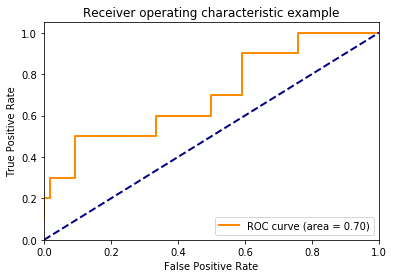

=====Generating test result=====
=====Done=====


In [4]:
tf.reset_default_graph()
model = RNN(dataloader, modeltype = 'lstm')
model.train()
model.validation()
model.test()

## Histogram of each feature

Since the values in training data is highly unbiased, we try to analyze the distribution of each feature and categorize them. The histograms below shows the distribution of non-zero values in each feature.


----ploting histogram----
ploting column 1


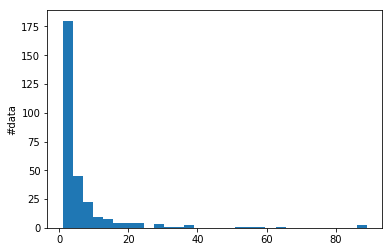

ploting column 2


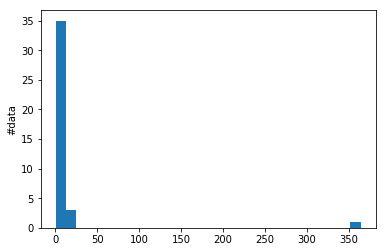

ploting column 3


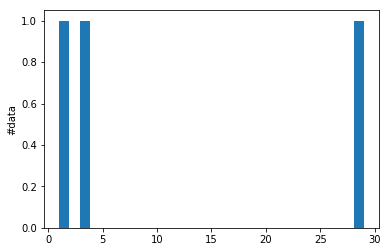

ploting column 4


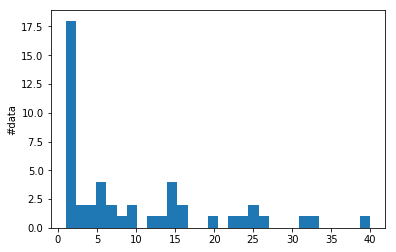

ploting column 5


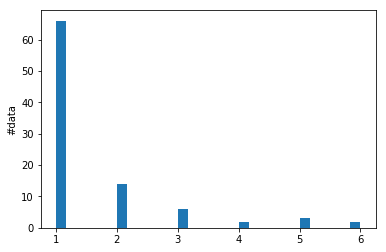

ploting column 6


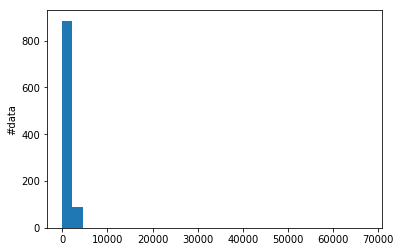

ploting column 7


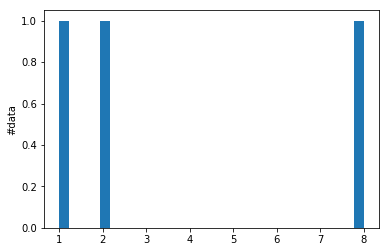

ploting column 8


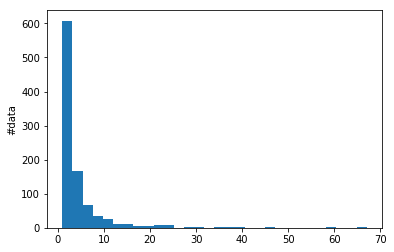

ploting column 9


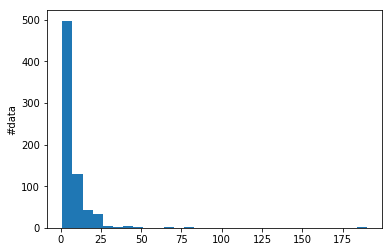

ploting column 10


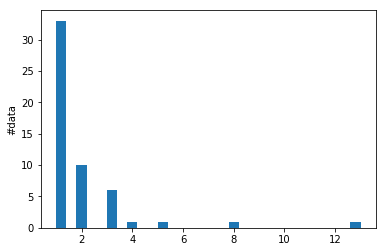

ploting column 11


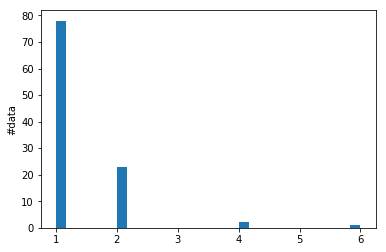

ploting column 12


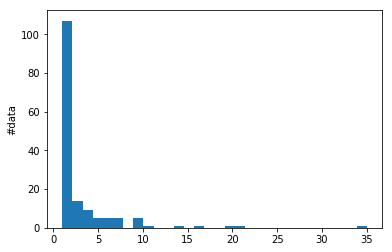

ploting column 13


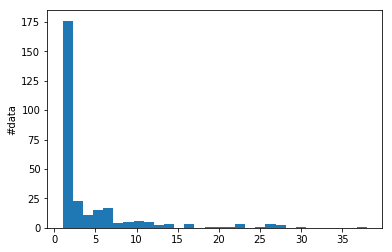

ploting column 14


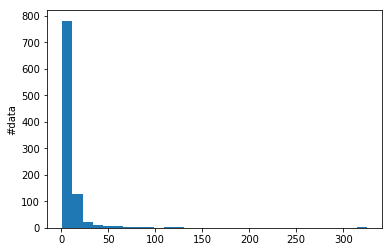

ploting column 15


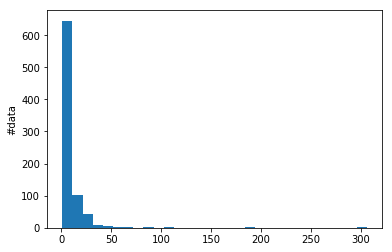

ploting column 16


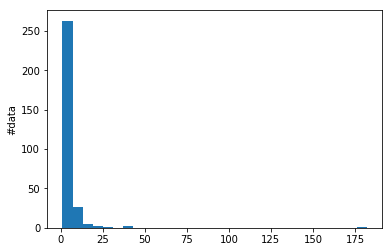

ploting column 17


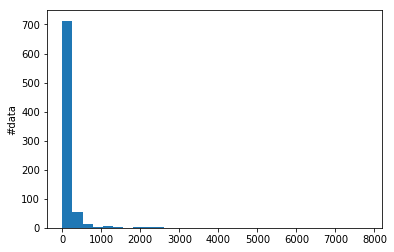

ploting column 18


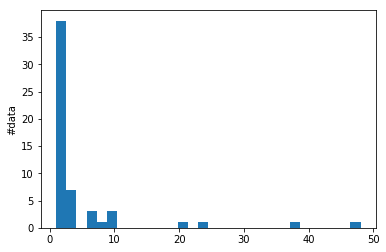

ploting column 19


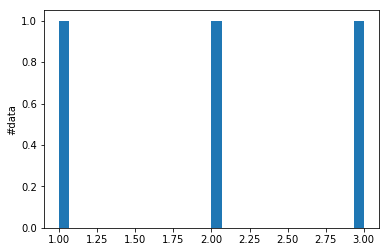

ploting column 20


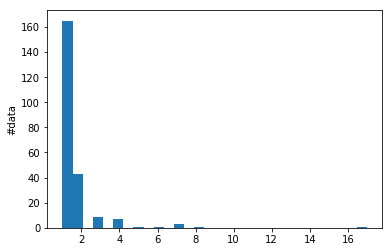

ploting column 21


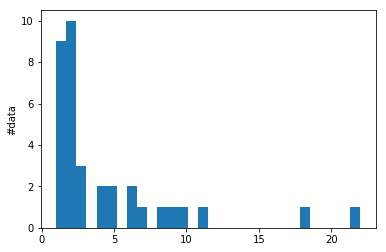

ploting column 22


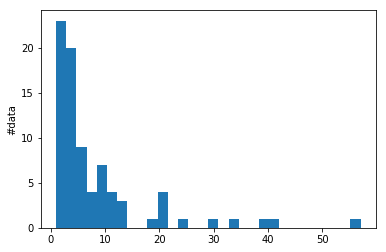

ploting column 23


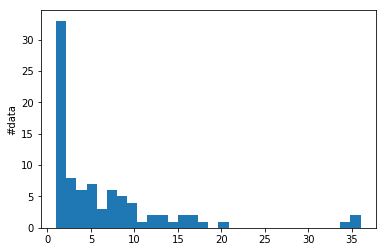

ploting column 24


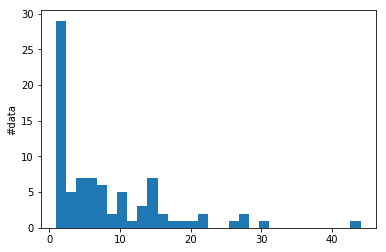

ploting column 25


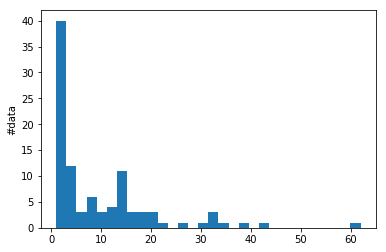

ploting column 26


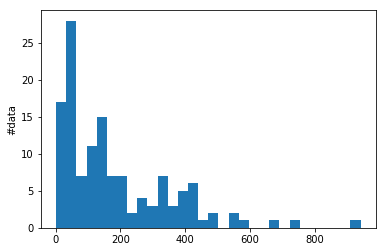

ploting column 27


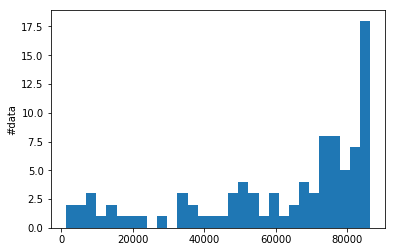

ploting column 28


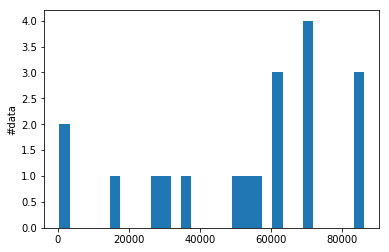

ploting column 29


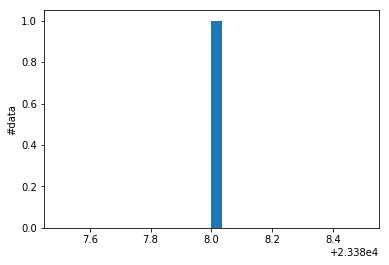

ploting column 30


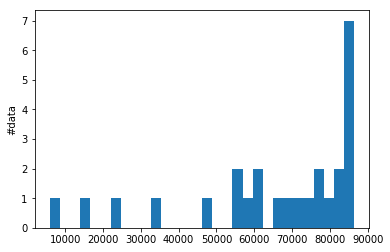

ploting column 31


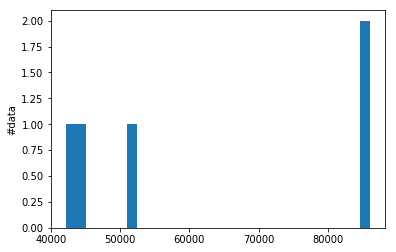

ploting column 32


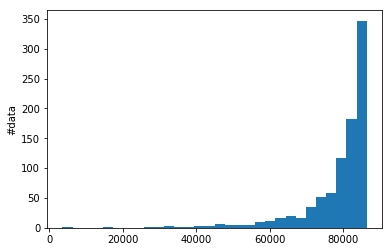

ploting column 33


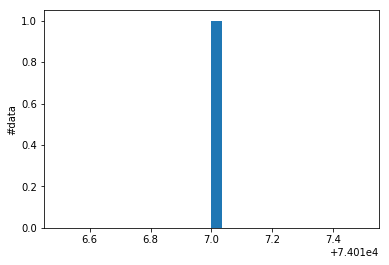

ploting column 34


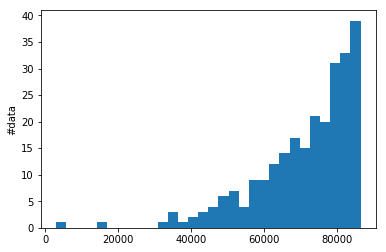

ploting column 35


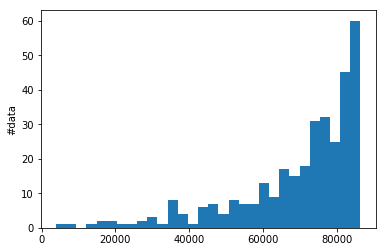

ploting column 36


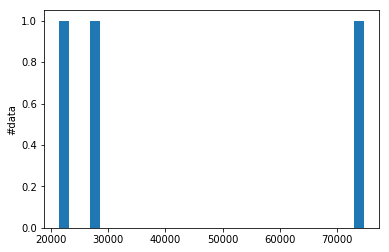

ploting column 37


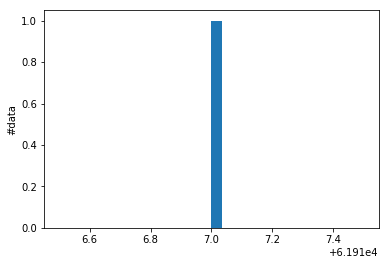

ploting column 38


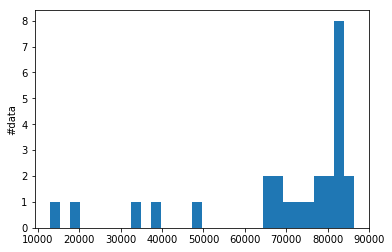

ploting column 39


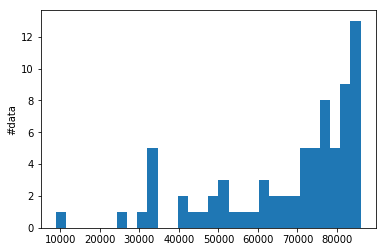

ploting column 40


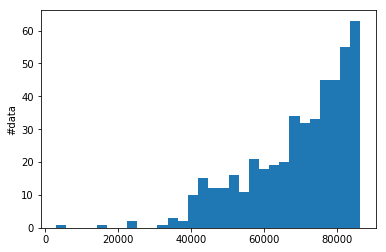

ploting column 41


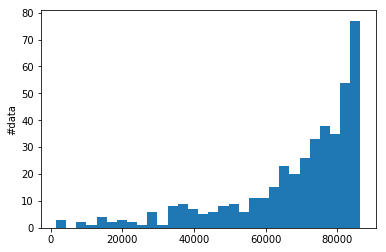

ploting column 42


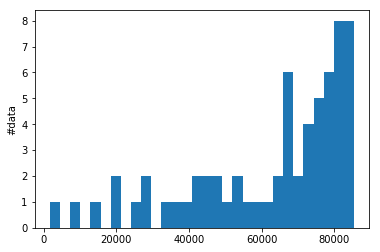

ploting column 43


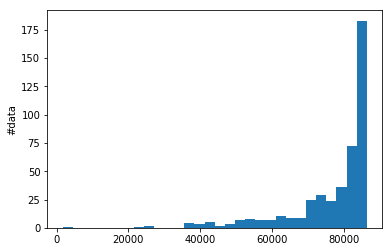

ploting column 44


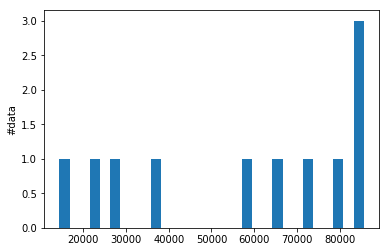

ploting column 45


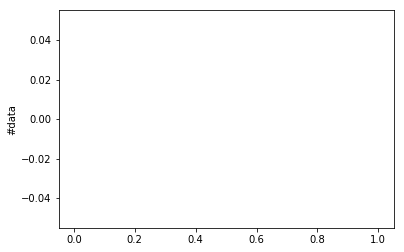

ploting column 46


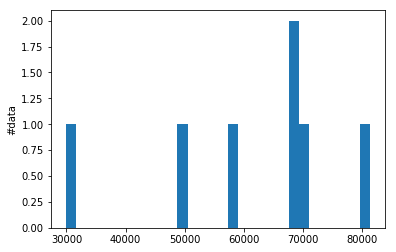

ploting column 47


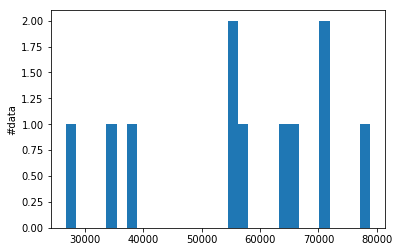

ploting column 48


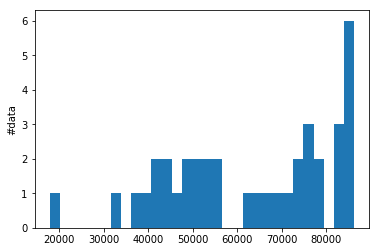

ploting column 49


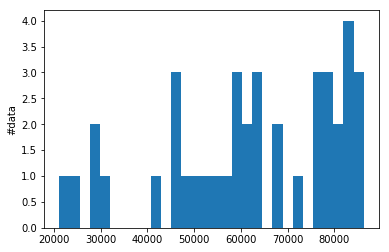

ploting column 50


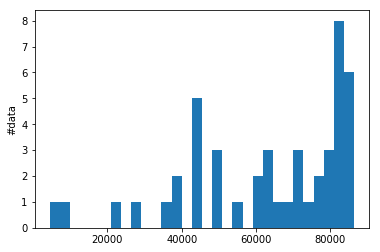

ploting column 51


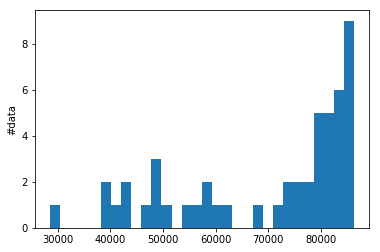

ploting column 52


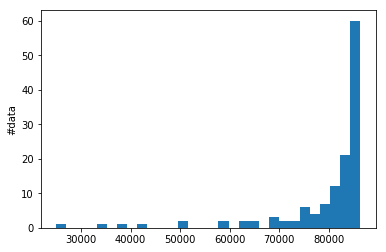

ploting column 53


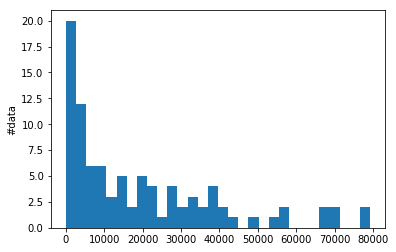

ploting column 54


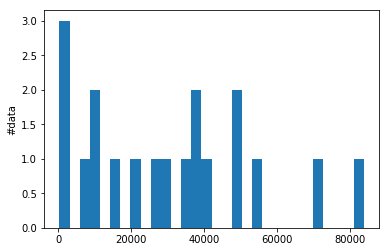

ploting column 55


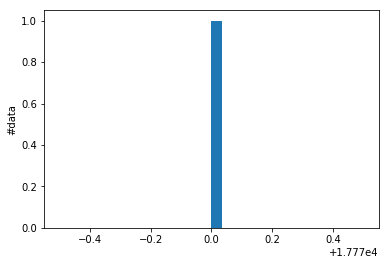

ploting column 56


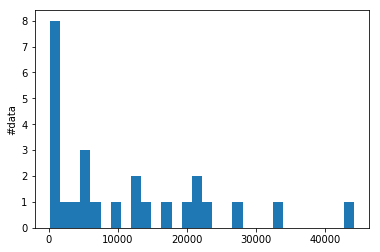

ploting column 57


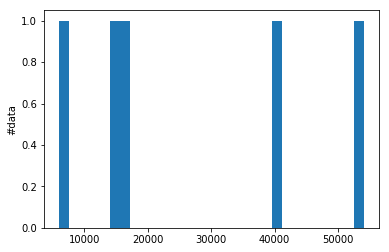

ploting column 58


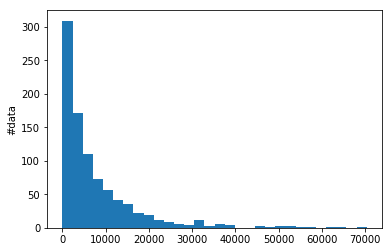

ploting column 59


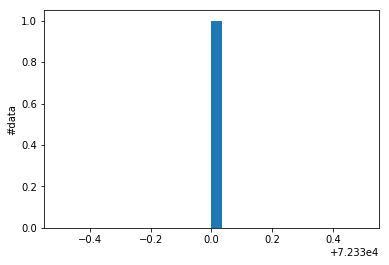

ploting column 60


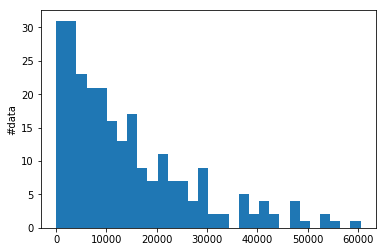

ploting column 61


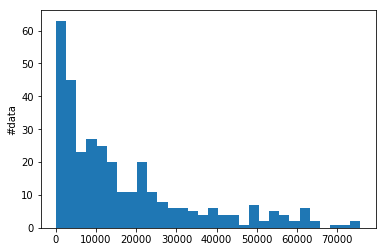

ploting column 62


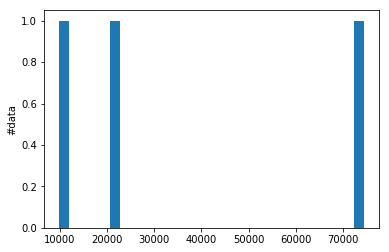

ploting column 63


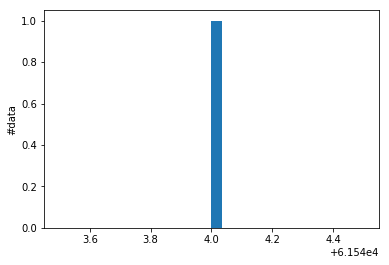

ploting column 64


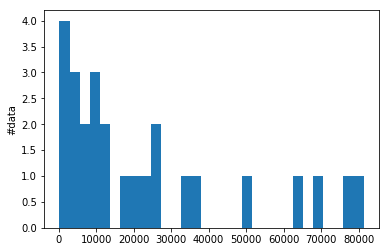

ploting column 65


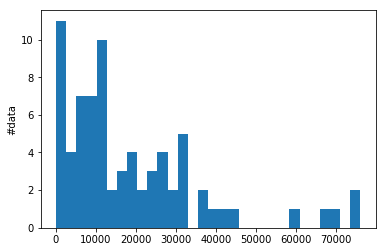

ploting column 66


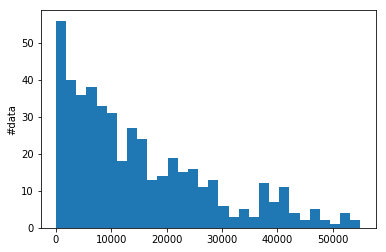

ploting column 67


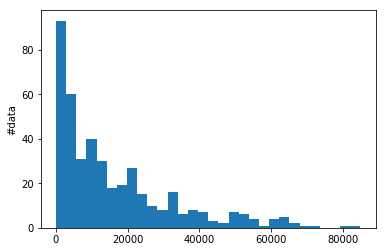

ploting column 68


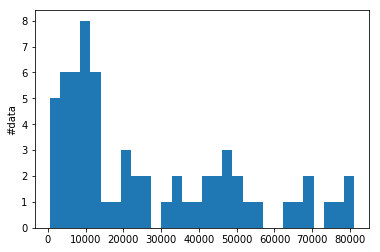

ploting column 69


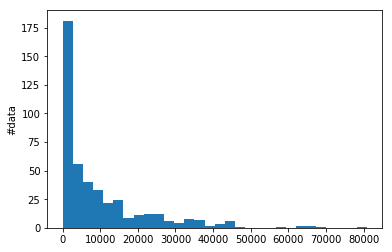

ploting column 70


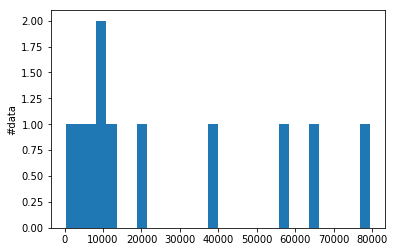

ploting column 71


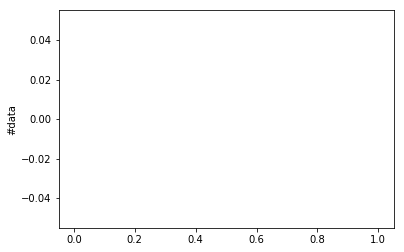

ploting column 72


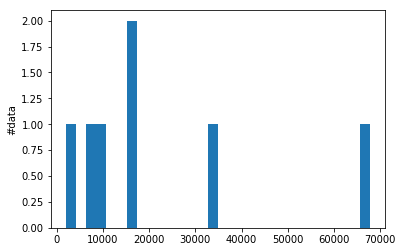

ploting column 73


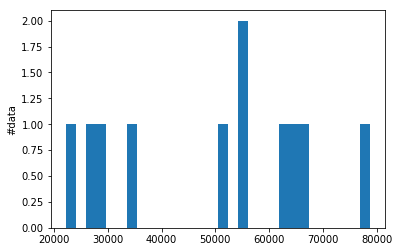

ploting column 74


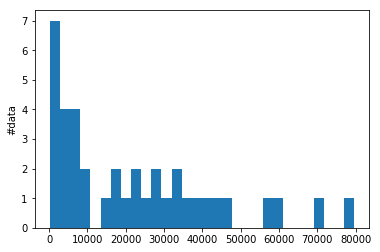

ploting column 75


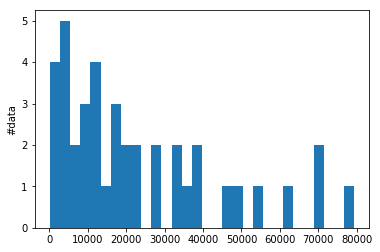

ploting column 76


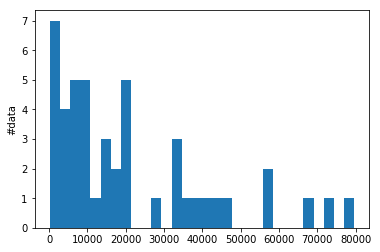

ploting column 77


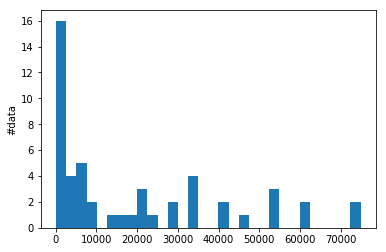

ploting column 78


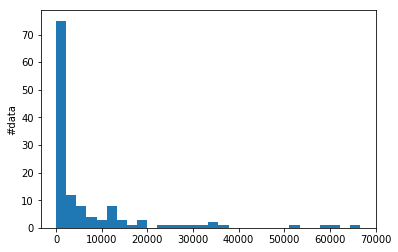

ploting column 79


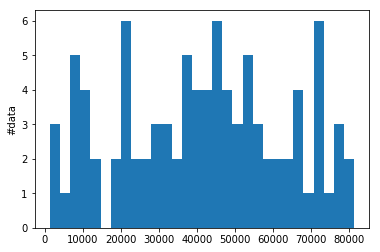

ploting column 80


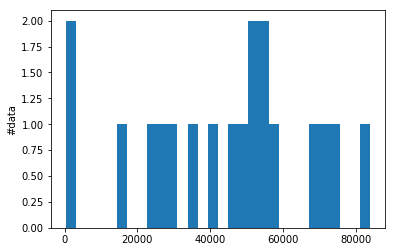

ploting column 81


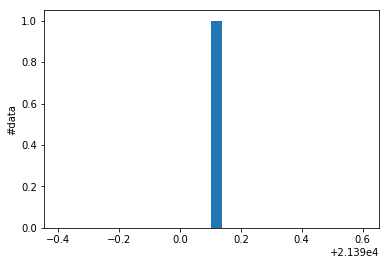

ploting column 82


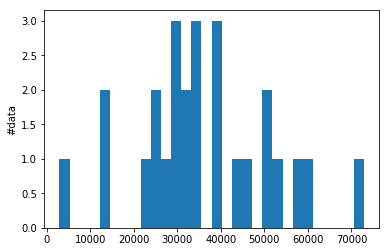

ploting column 83


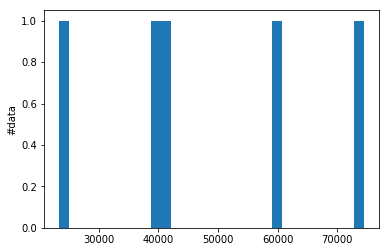

ploting column 84


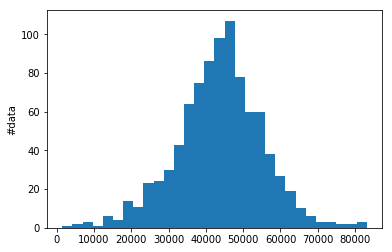

ploting column 85


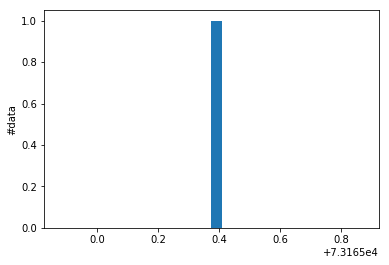

ploting column 86


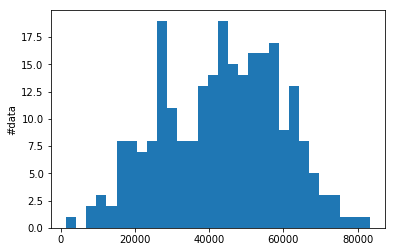

ploting column 87


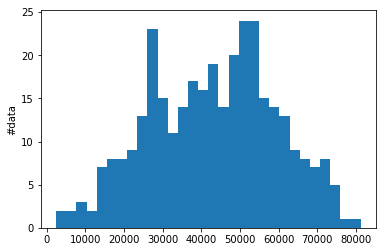

ploting column 88


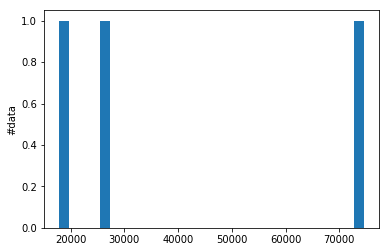

ploting column 89


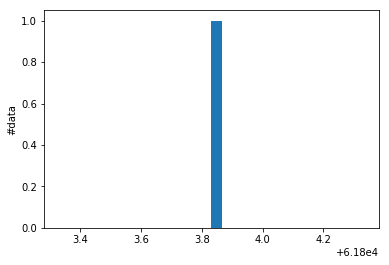

ploting column 90


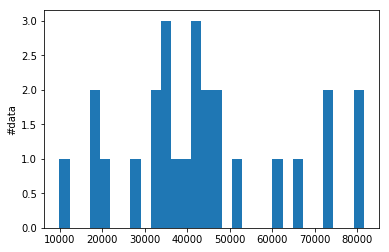

ploting column 91


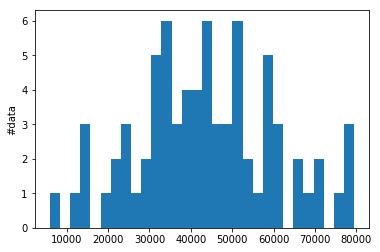

ploting column 92


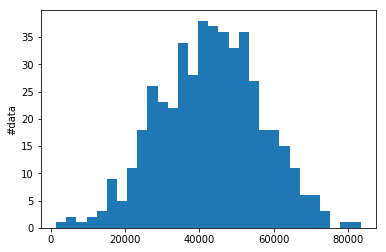

ploting column 93


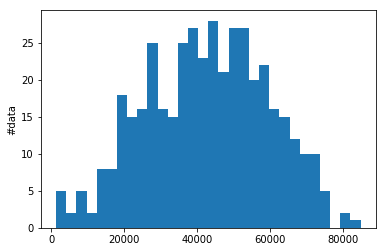

ploting column 94


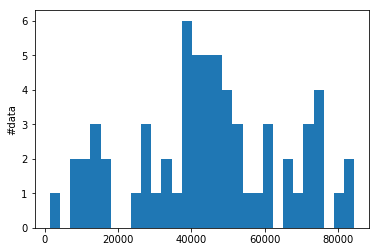

ploting column 95


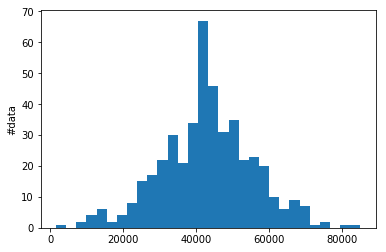

ploting column 96


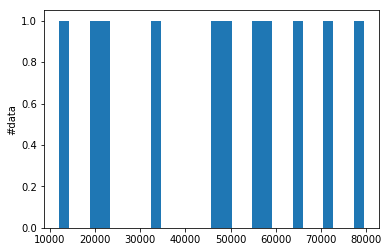

ploting column 97


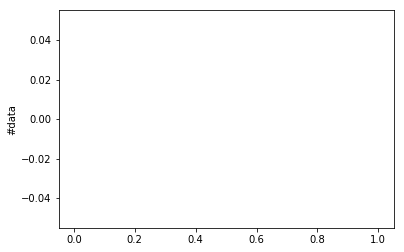

ploting column 98


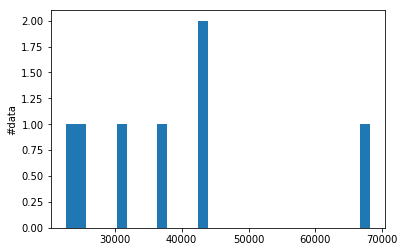

ploting column 99


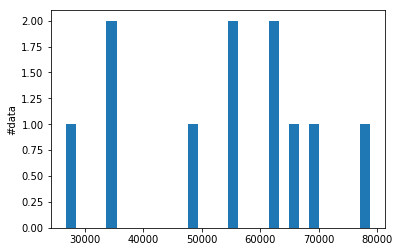

ploting column 100


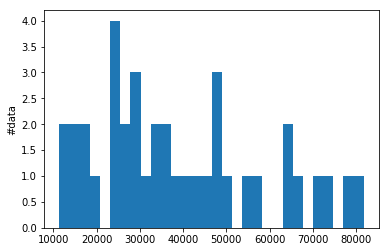

ploting column 101


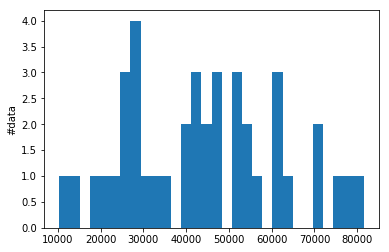

ploting column 102


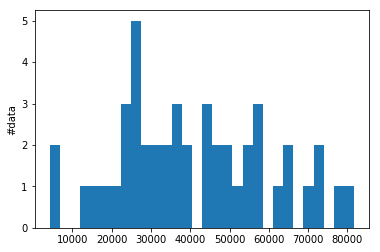

ploting column 103


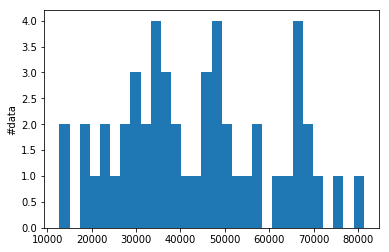

ploting column 104


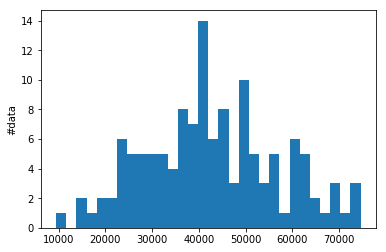

----ploting done----


<Figure size 432x288 with 0 Axes>

In [5]:
plot_histogram(dataloader.preserved_feature, remove_zero = True)

In the histograms, we find that some features are distributed like gaussian distribution while some are distributed like increasing/decreasing curve.
For features with high occurance, we labeled lower n-percentile as -1, upper n-percentile as 2 and other non zero entries as 1, 0 values are remain 0, where n is a hyper-parameter. 
For features with low occurance, we simply labeled non zero values as 1 and keep 0 values 0.

In training result, the validation accuracy is around 0.70, and this model ranked 4th place in kaggle leaderboard.